<a href="https://colab.research.google.com/github/GitAmitesh/SkinDiseaseClassificationCNN/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Skin Disease Classification using CNN


### Imports

In [28]:
import zipfile
import os
from google.colab import drive
import numpy as np
import pandas as pd
import seaborn as sns
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2

### Files extraction

##### DO NOT RUN THE EXTRACTION AGAIN AFTER FIRST EXECUTION

In [20]:
# !fusermount -u drive
# drive.mount('/content/drive')

# # Define the path of your ZIP file
# zip_path = "/content/drive/MyDrive/HAM10000/HAM10000.zip"  # Change this to your actual file path
# extraction_path = "/content/drive/MyDrive/HAM10000/"  # Change this to your desired extraction path

# # Extract the ZIP file
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extraction_path)  # Extract into a specific folder

# print("Dataset Extracted Successfully!")

In [32]:
extraction_path = "/content/drive/MyDrive/HAM10000/"
print("Folders and files inside dataset:")
print(os.listdir(extraction_path))  # Lists extracted files & folders

Folders and files inside dataset:
['HAM10000.zip', 'HAM10000_images_part_1', 'HAM10000_images_part_2', 'HAM10000_metadata.csv', 'ham10000_images_part_1', 'ham10000_images_part_2', 'hmnist_28_28_L.csv', 'hmnist_28_28_RGB.csv', 'hmnist_8_8_L.csv', 'hmnist_8_8_RGB.csv']


In [33]:
# Load metadata CSV file
metadata_path = os.path.join(extraction_path, "HAM10000_metadata.csv")  # Ensure correct file name
df = pd.read_csv(metadata_path)

# Display first few rows
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [34]:
# Get all image file paths
image_paths1 = glob.glob(os.path.join(extraction_path, "HAM10000_images_part_1", "*.jpg"))
image_paths2 = glob.glob(os.path.join(extraction_path, "HAM10000_images_part_2", "*.jpg"))

# Merge both image lists
all_image_paths = image_paths1 + image_paths2

# Convert list to dictionary for easy lookup
image_path_dict = {os.path.basename(path): path for path in all_image_paths}

# Add image paths to DataFrame
df["image_path"] = df["image_id"].map(lambda id: image_path_dict.get(id + ".jpg"))

# Display updated DataFrame
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,image_path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/HAM10000/HAM10000_image...
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/HAM10000/HAM10000_image...
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/HAM10000/HAM10000_image...
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/HAM10000/HAM10000_image...
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/drive/MyDrive/HAM10000/HAM10000_image...


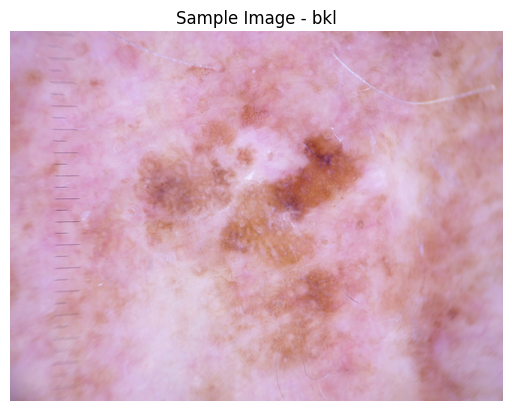

In [35]:
# Load and display a sample image using Matplotlib
sample_image_path = df.iloc[0]["image_path"]  # Get the image path
image = mpimg.imread(sample_image_path)  # Read the image as an array

plt.imshow(image)  # Display the image
plt.axis("off")  # Hide axes
plt.title(f"Sample Image - {df.iloc[0]['dx']}")  # Add title with disease label
plt.show()  # Show the image


In [36]:
df.isnull().sum()

,0
lesion_id,0
image_id,0
dx,0
dx_type,0
age,57
sex,0
localization,0
image_path,0


In [37]:
# The feature 'age' consists of 57 null records. Thus, we need to replace them with the mean of 'age' since dropping 57 records would lead to loss of data.
df['age'].fillna(int(df['age'].mean()),inplace=True)
df.isnull().sum()
# now the nulls are removed

<ipython-input-37-197812b8994a>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['age'].fillna(int(df['age'].mean()),inplace=True)


,0
lesion_id,0
image_id,0
dx,0
dx_type,0
age,0
sex,0
localization,0
image_path,0


In [38]:
# Define the dictionary mapping lesion codes to their full names
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

# Map diagnosis labels to full cell type names
df['lesion_type'] = df['dx'].map(lesion_type_dict.get)

# Encode cell type labels as numerical values
df['lesion_type_idx'] = pd.Categorical(df['lesion_type']).codes

# Display the first few rows
df.head()


,lesion_id,image_id,dx,dx_type,age,sex,localization,image_path,lesion_type,lesion_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/HAM10000/HAM10000_image...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/HAM10000/HAM10000_image...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/HAM10000/HAM10000_image...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/HAM10000/HAM10000_image...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/drive/MyDrive/HAM10000/HAM10000_image...,Benign keratosis-like lesions,2


<ipython-input-39-0031d229d10b>:23: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sample_age['age'], fit=stats.norm, color='red');


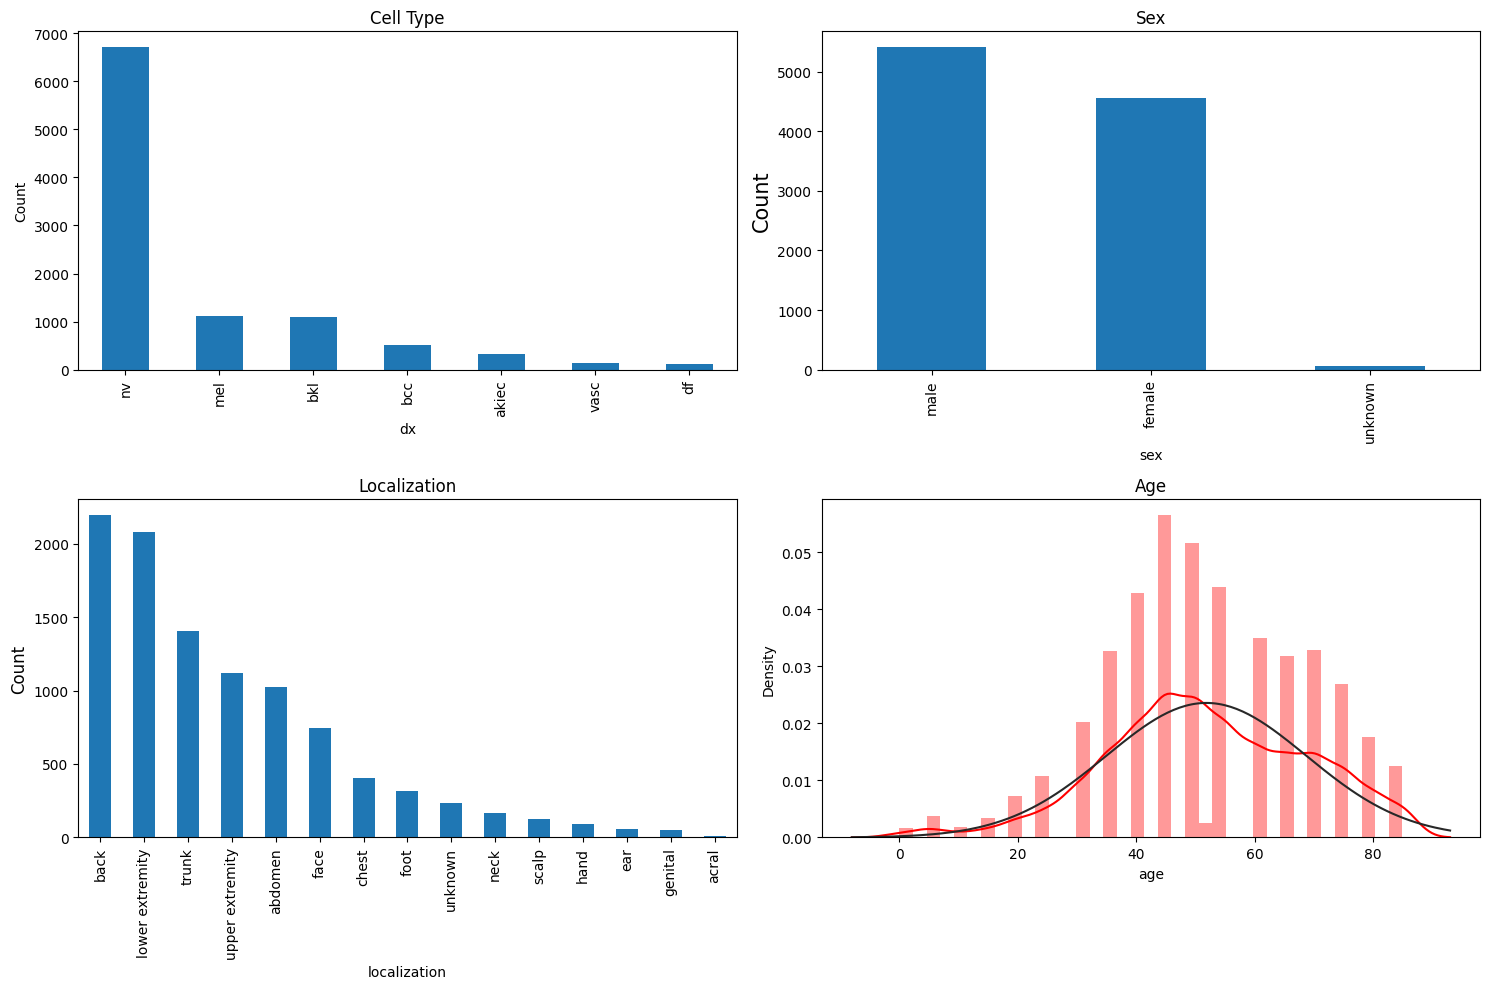

In [39]:
# Data distribution visualization
from scipy import stats
fig = plt.figure(figsize=(15,10))

ax1 = fig.add_subplot(221)
df['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type');

ax2 = fig.add_subplot(222)
df['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex');

ax3 = fig.add_subplot(223)
df['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Localization')


ax4 = fig.add_subplot(224)
sample_age = df[pd.notnull(df['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='red');
ax4.set_title('Age')

plt.tight_layout()
plt.show()

According to "dx" graph plot, we can observe that the dataset is heavily unbalanced and needs to be balanced using data augmentation. Data augmentation is a technique that artificially increases the size and diversity of a dataset by creating modified copies of existing data, improving model performance and robustness, especially when dealing with limited data.


In [42]:
print("Number of data points per cell type before augmentation:")
print(df['dx'].value_counts())

Number of data points per cell type before augmentation:
dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


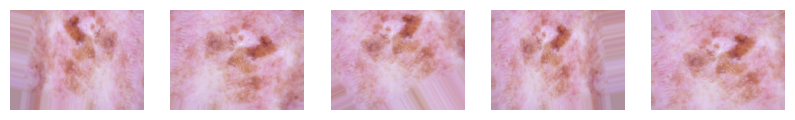

In [40]:
# Define augmentation techniques
datagen = ImageDataGenerator(
    rotation_range=30,      # Rotate images up to 30 degrees
    width_shift_range=0.1,  # Shift width by 10%
    height_shift_range=0.1, # Shift height by 10%
    shear_range=0.2,        # Shear transformation
    zoom_range=0.2,         # Random zoom
    horizontal_flip=True,   # Flip horizontally
    fill_mode='nearest'     # Fill missing pixels after transformation
)

# Example: Augment a sample image
sample_image = cv2.imread(df.iloc[0]['image_path'])  # Read first image
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)  # Convert to RGB
sample_image = sample_image.reshape((1,) + sample_image.shape)  # Reshape for augmentation

print("Data/Image augmentation example sample")
# Generate augmented images and display them
plt.figure(figsize=(10, 5))
for i, batch in enumerate(datagen.flow(sample_image, batch_size=1)):
    plt.subplot(1, 5, i + 1)
    plt.imshow(batch[0].astype('uint8'))
    plt.axis('off')
    if i == 4: break  # Show only 5 examples
plt.show()